In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import pandas

2023-12-05 22:39:14.875637: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 22:39:14.912990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file = "../train.tsv"
test_file = "../test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,0:1] = train_data2[:, 0:1] * 2.7 / 4   #季節を正規化
train_data2[:,2:3] = train_data2[:, 2:3] * 1.8 / 12 #月を正規化
train_data2[:,3:4] = train_data2[:, 3:4] * 62.3 / 23 #時間を正規化
train_data2[:,5:6] = train_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
train_data2[:,7:8] = train_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
train_data2[:,4:5] = train_data2[:, 4:5] * 0.2
train_data2[:,6:7] = train_data2[:, 6:7] * 5.6
train_data2[:,8:9] = train_data2[:, 8:9] * 9.5
train_data2[:,9:10] = train_data2[:, 9:10] * 8.9
train_data2[:,10:11] = train_data2[:, 10:11] * 3.4
train_data2[:,11:12] = train_data2[:, 11:12] * 1.5

train_data2 = train_data2#.astype(np.float32)
rnd = np.random.default_rng()
rnd.shuffle(train_data2,axis=0)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,0:1] = test_data2[:, 0:1] * 2.7 / 4   #季節を正規化
test_data2[:,2:3] = test_data2[:, 2:3] * 1.8 / 12 #月を正規化
test_data2[:,3:4] = test_data2[:, 3:4] * 62.3 / 23 #時間を正規化
test_data2[:,5:6] = test_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
test_data2[:,7:8] = test_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
test_data2[:,4:5] = test_data2[:, 4:5] * 0.2
test_data2[:,6:7] = test_data2[:, 6:7] * 5.6
test_data2[:,8:9] = test_data2[:, 8:9] * 9.5
test_data2[:,9:10] = test_data2[:, 9:10] * 8.9
test_data2[:,10:11] = test_data2[:, 10:11] * 3.4
test_data2[:,11:12] = test_data2[:, 11:12] * 1.5
test_data2 = test_data2#.astype(np.float32)

display(train_data2)
display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
#print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1], 1)
#print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)
z = test_data2[:, :12]
z = z.reshape(z.shape[0], z.shape[1], 1)

array([[1.3500e+00, 0.0000e+00, 6.0000e-01, ..., 1.4620e+00, 2.0145e-01,
        3.8700e+02],
       [2.7000e+00, 0.0000e+00, 1.6500e+00, ..., 2.2780e+00, 2.9100e-01,
        4.5200e+02],
       [2.7000e+00, 0.0000e+00, 1.6500e+00, ..., 2.2780e+00, 3.8055e-01,
        1.9000e+01],
       ...,
       [2.0250e+00, 0.0000e+00, 1.0500e+00, ..., 2.8560e+00, 5.8215e-01,
        1.1200e+02],
       [2.7000e+00, 0.0000e+00, 1.5000e+00, ..., 2.5840e+00, 3.8055e-01,
        8.7000e+01],
       [2.7000e+00, 0.0000e+00, 1.8000e+00, ..., 1.5640e+00, 3.8055e-01,
        1.2400e+02]])

array([[0.675  , 1.     , 0.15   , ..., 3.37132, 2.244  , 0.     ],
       [0.675  , 1.     , 0.15   , ..., 3.10165, 2.244  , 0.20145],
       [0.675  , 1.     , 0.15   , ..., 3.10165, 2.584  , 0.     ],
       ...,
       [0.675  , 1.     , 1.8    , ..., 2.29264, 2.04   , 0.2463 ],
       [0.675  , 1.     , 1.8    , ..., 2.42703, 1.904  , 0.20145],
       [0.675  , 1.     , 1.8    , ..., 2.42703, 2.21   , 0.20145]])

In [3]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 4096  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加 #増やした

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

2023-12-05 22:39:17.409942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:39:17.438381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:39:17.438421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:39:17.441033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:39:17.441069: I tensorflow/compile

In [4]:
#def build_model(hp):
#  import keras
#  model = keras.Sequential()
#  model.add(keras.layers.Dense(
#      hp.Choice('units', [8, 16, 32]),
#      activation='relu'))
#  model.add(keras.layers.Dense(1, activation='relu'))
#  model.compile(loss='mse')
#  return model

#tuner = kt.RandomSearch(
#    build_model,
#    objective='val_loss',
#    max_trials=5)

#tuner.search(train_data2, epochs=5, validation_data=(train_data2))
#best_model = tuner.get_best_models()[0]

In [5]:
ES = EarlyStopping(mode='auto', patience=32)
model.fit(y, x,
          batch_size=32, #デフォは32
          epochs=512, #512epochで学習
          validation_split=0.2, #学習データの5%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/512


2023-12-05 22:39:48.934696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-12-05 22:39:50.036052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 22:39:50.072455: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f974c22cf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 22:39:50.072506: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-05 22:39:50.079299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 22:39:50.181356: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

217/217 [==============================] - 19s 69ms/step - loss: 18370.7754 - accuracy: 0.0130 - val_loss: 18124.6074 - val_accuracy: 0.0098
Epoch 2/512
217/217 [==============================] - 14s 67ms/step - loss: 17871.7891 - accuracy: 0.0133 - val_loss: 18124.9043 - val_accuracy: 0.0098
Epoch 3/512
217/217 [==============================] - 15s 67ms/step - loss: 17867.1582 - accuracy: 0.0133 - val_loss: 18230.8301 - val_accuracy: 0.0098
Epoch 4/512
217/217 [==============================] - 15s 67ms/step - loss: 17913.7227 - accuracy: 0.0133 - val_loss: 18127.2832 - val_accuracy: 0.0098
Epoch 5/512
217/217 [==============================] - 15s 67ms/step - loss: 17895.5879 - accuracy: 0.0133 - val_loss: 18140.0527 - val_accuracy: 0.0098
Epoch 6/512
217/217 [==============================] - 15s 67ms/step - loss: 17900.6660 - accuracy: 0.0133 - val_loss: 18138.3320 - val_accuracy: 0.0098
Epoch 7/512
217/217 [==============================] - 15s 67ms/step - loss: 17887.0195 - accu

KeyboardInterrupt: 

In [6]:
predicted = model.predict(y,batch_size=32)
model.evaluate(y,x,batch_size=32)

271/271 [==============================] - 7s 25ms/step - loss: 4277.4263 - accuracy: 0.0126


[4277.42626953125, 0.012608444318175316]

In [7]:
r2 = 1 -  np.sum((predicted - x)**2) / np.sum((x - np.mean(x))**2)
print(r2)

0.7610348432824426


In [8]:
predicted

array([[159.50414 ],
       [316.5966  ],
       [ 22.72977 ],
       ...,
       [176.65945 ],
       [108.918846],
       [155.90495 ]], dtype=float32)

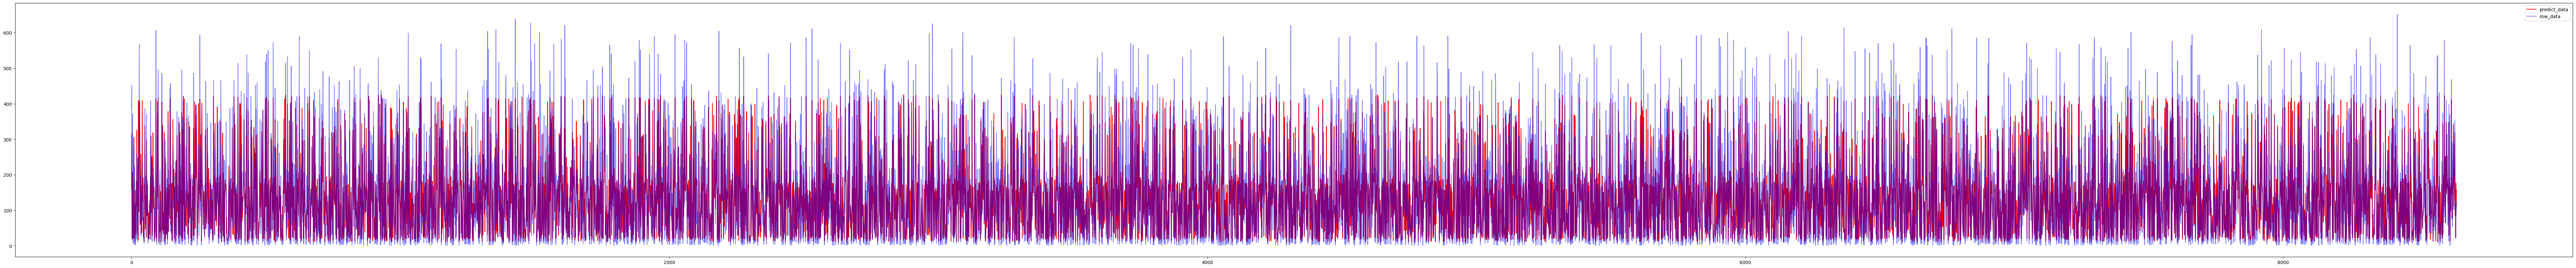

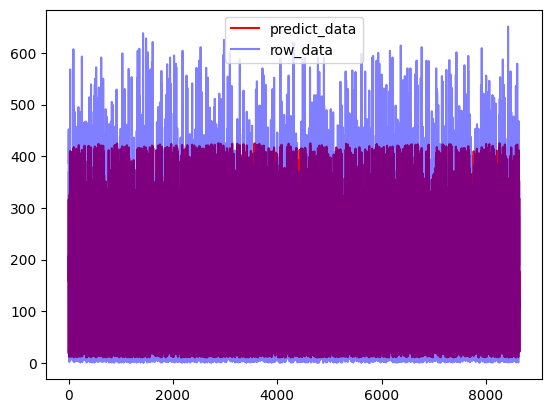

In [9]:
plt.figure(figsize=(100,10))
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

273/273 [==============================] - 6s 24ms/step
[[13]
 [12]
 [11]
 ...
 [57]
 [41]
 [35]]
13
12
11
10
10
11
14
29
50
66
80
96
109
114
120
131
104
110
105
84
75
47
35
31
13
13
12
10
11
15
29
47
61
74
84
88
92
96
101
91
97
93
76
64
40
31
28
13
12
11
10
11
13
19
61
105
115
79
80
80
81
82
89
118
149
143
108
72
55
39
33
13
12
11
10
11
13
19
55
91
103
75
76
78
79
81
90
124
165
161
116
74
57
41
34
13
12
11
10
11
13
21
72
117
122
81
85
86
89
90
100
140
184
175
126
78
58
42
35
13
12
11
10
11
14
21
78
120
123
83
85
89
92
96
110
165
199
197
139
83
61
44
37
13
13
12
11
11
12
16
31
51
62
81
97
110
118
129
144
112
118
114
90
78
47
35
31
13
12
11
10
10
11
14
31
52
72
83
98
104
109
112
121
101
103
98
79
66
41
31
28
13
12
11
10
11
13
19
70
116
125
83
83
84
85
86
94
128
170
166
117
74
57
41
34
13
12
11
11
14
19
68
113
120
81
91
92
92
94
103
144
186
179
127
77
59
42
35
13
12
11
10
11
13
20
70
114
120
83
85
88
89
91
102
142
185
181
130
80
60
44
37
13
13
11
11
11
14
24
91
133
138
88
89
90
95
96
107

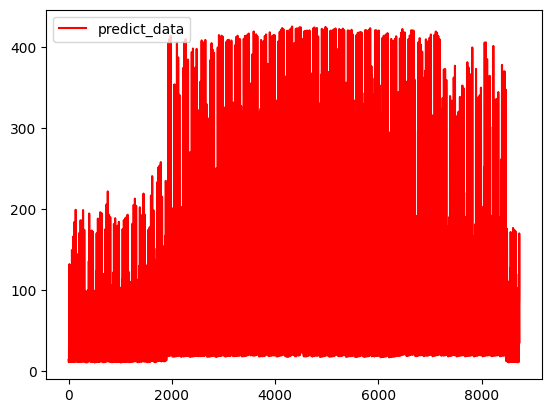

In [11]:
predictedz = model.predict(z,batch_size=32)
zzzzzz = predictedz.astype("int32")
print(zzzzzz)
shit = 0
for i in range(0,8733):
    print(zzzzzz[i,0])
    if zzzzzz[i,0] < 0:
        shit += 1
print(np.shape(zzzzzz))
print(shit)

plt.figure()
plt.plot(range(0,len(zzzzzz)),predictedz, color="r", label="predict_data")
plt.legend()
plt.show()